# 2024 Jan 26 Shanghai University, MGI

+ 数据说明与读取
+ 通过Bgolearn 进行主动学习
+ 数据更新

[主页](https://github.com/Bin-Cao/Bgolearn)
[算法更多设置](https://bgolearn.netlify.app/)
(点击查看）

使用过程有任何疑问：欢迎来邮 （binjacobcao@gmail.com）

## 1 : 数据说明与读取

In [2]:
import pandas as pd

# ./data/data.csv 是文件所在路径
data = pd.read_csv('./data/data.csv')

# 输出前五行看看
print('数据前五行 :\n ', data.head(5))

print('\n 数据总数 :',len(data))

数据前五行 :
       Sn   Bi   In   Ti      T      E
0  92.9  3.0  2.5  0.1  64.60  20.85
1  92.7  3.0  2.5  0.3  62.59  23.69
2  92.5  3.0  2.5  0.5  72.05  22.84
3  91.9  3.0  3.5  0.1  66.60  19.79
4  91.7  3.0  3.5  0.3  70.29  21.60

 数据总数 : 27


+ 包括4个特征，Sn   Bi   In   Ti (wt.%) 和两个目标 T (抗拉强度， MPa) E(断裂延伸率， %)
+ 这个样本集，就是我们常说的主动学习的训练样本， 包括特征和目标值

In [3]:
# ./data/Visual_samples.csv 是文件所在路径
VS_data = pd.read_csv('./data/Visual_samples.csv')

# 输出前五行看看
print('数据前五行 :\n ', VS_data.head(5))

print('\n 数据总数 :',len(VS_data))

数据前五行 :
       Sn   Bi   In   Ti
0  95.4  1.5  1.5  0.1
1  95.3  1.5  1.5  0.2
2  95.2  1.5  1.5  0.3
3  95.1  1.5  1.5  0.4
4  95.0  1.5  1.5  0.5

 数据总数 : 11767


+ 包括4个特征，Sn   Bi   In   Ti (wt.%) **不包括目标值**
+ 这个样本集，就是我们常说的主动学习的虚拟样本空间

### 在这个数据集中，虚拟样本是通过正交设计得来

+ 虚拟样本设计 ： 参考[代码模版](https://mp.weixin.qq.com/s?__biz=MzkzNDQ3OTAyMg==&mid=2247484024&idx=1&sn=e1dc5c7f59a37d050fb12cd0d3f35660&chksm=c2bdd7b9f5ca5eafea4572d725a2cd421d8af780cd3a74187ad2197ce863d3e1a1c698bf47a9#rd) 
 
+ 关于数据更多介绍，参考文章 ： Cao, Bin and Su, Tianhao and Yu, Shuting and Li, Tianyuan and Zhang, Taolue and Dong, Ziqiang and Zhang, Tong-Yi, Active Learning Accelerates the Discovery of High Strength and High Ductility Lead-Free Solder Alloys. Available at SSRN: http://dx.doi.org/10.2139/ssrn.4686075. 

In [4]:
"""
# 本文中虚拟样本生成的代码
import numpy as np

Bi = np.arange(1.5, 5.6, 0.1)
In = np.arange(1.5, 5.6, 0.1)
Ti = np.arange(0.1, 0.8, 0.1)

X1,X2,X3 = np.meshgrid(Bi,In,Ti)
Visual_samples = np.vstack([X1.ravel(), X2.ravel(),X3.ravel()]).T
Visual_samples = pd.DataFrame(Visual_samples)
Visual_samples.columns=['Bi','In','Ti']

Sn = 100 - 1.5 - Visual_samples['Bi'] - Visual_samples['In'] - Visual_samples['Ti']
Visual_samples.insert(0, 'Sn', Sn)
Visual_samples.to_csv('./data/Visual_samples.csv',index=0)
"""

"\n# 本文中虚拟样本生成的代码\nimport numpy as np\n\nBi = np.arange(1.5, 5.6, 0.1)\nIn = np.arange(1.5, 5.6, 0.1)\nTi = np.arange(0.1, 0.8, 0.1)\n\nX1,X2,X3 = np.meshgrid(Bi,In,Ti)\nVisual_samples = np.vstack([X1.ravel(), X2.ravel(),X3.ravel()]).T\nVisual_samples = pd.DataFrame(Visual_samples)\nVisual_samples.columns=['Bi','In','Ti']\n\nSn = 100 - 1.5 - Visual_samples['Bi'] - Visual_samples['In'] - Visual_samples['Ti']\nVisual_samples.insert(0, 'Sn', Sn)\nVisual_samples.to_csv('./data/Visual_samples.csv',index=0)\n"

#### 主动学习的设计目标是通过，看过训练数据（39个有标签的数据）里的信息，在虚拟空间中（11767个没标签的数据）中推荐“最具潜力”的样本

## 2 : 通过Bgolearn 进行主动学习

+ 第一次使用时，请先安装 Bgolearn 到电脑上

+ 查看版本

In [5]:
pip show Bgolearn 

Name: Bgolearn
Version: 2.3.1
Summary: A Bayesian global optimization package for material design
Home-page: https://github.com/Bin-Cao/Bgolearn
Author: CaoBin
Author-email: bcao@shu.edu.com
License: MIT License
Location: /Users/jacob/miniconda3/lib/python3.9/site-packages
Requires: art, matplotlib, multiprocess, numpy, pandas, scikit-learn, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


### 显示版本为Version: 2.2.4， 安装到本地位置/Users/jacob/miniconda3/lib/python3.9/site-packages
### 此为当前最新版本 （Jan 2024）

+ 以下为代码模版，无需更改

In [6]:
# 安装后, 通过此命令调用BGOsampling类
import Bgolearn.BGOsampling as BGOS


# 读入我们使用的数据
data = pd.read_csv('./data/data.csv') 
vs = pd.read_csv('./data/Visual_samples.csv')


# 在此研究中，变量是元素含量 ： Sn, Bi, In, Ti, 也就是前四列
x = data.iloc[:,:-2] # 这行代码读取前四列，是特征

y = data.iloc[:,-2] # 这行代码读取倒数第二列，是特征, 抗拉强度 T


# 模版
# min_search=True 最小化目标
# min_search=False 最大化目标
Bgolearn = BGOS.Bgolearn() 
Mymodel = Bgolearn.fit(data_matrix = x, Measured_response = y, virtual_samples = vs, min_search=False)
Mymodel.EI() # 通过EI 函数从虚拟空间选择点

 ____                 _                           
| __ )   __ _   ___  | |  ___   __ _  _ __  _ __  
|  _ \  / _` | / _ \ | | / _ \ / _` || '__|| '_ \ 
| |_) || (_| || (_) || ||  __/| (_| || |   | | | |
|____/  \__, | \___/ |_| \___| \__,_||_|   |_| |_|
        |___/                                     

Bgolearn, Bin CAO, HKUST(GZ)
URL : https://github.com/Bin-Cao/Bgolearn and https://bgolearn.netlify.app/
Citation: 
Materials & Design : https://doi.org/10.1016/j.matdes.2024.112921
NPJ Computational Materials : https://doi.org/10.1038/s41524-024-01243-4
Executed on : 2024-04-16 17:17:33  | Have a great day.
The internal model is instantiated with optimized homogenous noise
current optimal is : 113.44
The next datum recomended by Expected Improvement : 
 x =  [87.1  5.5  5.5  0.4]
The predictions of Bgolearn are : 
 y =  103.93545425132407


(array([1.01196525e-06, 3.62815136e-07, 3.75460856e-07, ...,
        3.62891429e-01, 3.21302045e-01, 3.50731033e-01]),
 array([[87.1,  5.5,  5.5,  0.4]]))

In [7]:
## 试着换成基于SVM建模

# 安装后, 通过此命令调用BGOsampling类
import Bgolearn.BGOsampling as BGOS


# 读入我们使用的数据
data = pd.read_csv('./data/data.csv') 
vs = pd.read_csv('./data/Visual_samples.csv')


# 在此研究中，变量是元素含量 ： Sn, Bi, In, Ti, 也就是前四列
x = data.iloc[:,:-2] # 这行代码读取前四列，是特征

y = data.iloc[:,-2] # 这行代码读取倒数第二列，是特征, 抗拉强度 T


# 模版
# min_search=True 最小化目标
# min_search=False 最大化目标
Bgolearn = BGOS.Bgolearn() 
Mymodel = Bgolearn.fit(data_matrix = x, Measured_response = y, virtual_samples = vs, min_search=False,Kriging_model='SVM')
Mymodel.EI() # 通过EI 函数从虚拟空间选择点

 ____                 _                           
| __ )   __ _   ___  | |  ___   __ _  _ __  _ __  
|  _ \  / _` | / _ \ | | / _ \ / _` || '__|| '_ \ 
| |_) || (_| || (_) || ||  __/| (_| || |   | | | |
|____/  \__, | \___/ |_| \___| \__,_||_|   |_| |_|
        |___/                                     

Bgolearn, Bin CAO, HKUST(GZ)
URL : https://github.com/Bin-Cao/Bgolearn and https://bgolearn.netlify.app/
Citation: 
Materials & Design : https://doi.org/10.1016/j.matdes.2024.112921
NPJ Computational Materials : https://doi.org/10.1038/s41524-024-01243-4
Executed on : 2024-04-16 17:17:37  | Have a great day.
The internal model is assigned
Bgolearn model :  SVR()
Bgolearn model :  SVR()
current optimal is : 113.44
The next datum recomended by Expected Improvement : 
 x =  [87.2  5.5  5.2  0.6]
The predictions of Bgolearn are : 
 y =  86.24043348011374


(array([2.83381254e-81, 6.90340668e-89, 3.28288488e-94, ...,
        1.25781244e-19, 5.46802917e-18, 2.61854962e-18]),
 array([[87.2,  5.5,  5.2,  0.6]]))

### 通过 EI方法推荐了样本 [87.1  5.5  5.5  0.4] , 预测的性能值是 y =  104.756450943749

除了EI 还可以更改为其他的效用函数， 只需将Mymodel.EI()替换为：

+ Mymodel.Augmented_EI(alpha = 1, tao = 0)

:param alpha: tradeoff coefficient, default 1, recommended [0,3]
:param tao: noise standard deviation, default 0, recommended [0,1]

+ Mymodel.EQI(beta = 0.5,tao_new = 0)

:param beta: beta quantile number, default 0.5, recommended [0.2,0.8]
:param tao: noise standard deviation, default 0, recommended [0,1]

+ Mymodel.UCB(alpha=1)

:param alpha: tradeoff coefficient, default 1, recommended [0,3]

+ Mymodel.PoI(tao = 0)

:param tao: improvement ratio (>=0) , default 0, recommended [0,0.3]

+ Mymodel.PES(sam_num = 500)

:param sam_num: number of optimal drawn from p(x*|D), default 500, recommended [100,1000]

+ Mymodel.Knowledge_G(MC_num = 50)

:param MC_num: number of Monte carlo sampling, default 50, recommended [50,300]

## 3 ：数据更新

### 通过实验方法合成样本 [95.3,  1.5,  1.5,  0.2] , 测试性能值 y， 将这个样本添加到 训练数据 data.csv， 重复此优化过程

---

# 以上我们只针对 目标性能抗拉强度 T做了优化，并未考虑另一个性能，断裂延伸率E。 接下来我们考虑两个性能

In [8]:
# 安装后, 通过此命令调用BGOsampling类
import Bgolearn.BGOsampling as BGOS


# 读入我们使用的数据
data = pd.read_csv('./data/data.csv') 
vs = pd.read_csv('./data/Visual_samples.csv')


# 在此研究中，变量是元素含量 ： Sn, Bi, In, Ti, 也就是前四列
x = data.iloc[:,:-2] # 这行代码读取前四列，是特征

y_T = data.iloc[:,-2] # 这行代码读取倒数第二列，是目标, 抗拉强度 T
y_E = data.iloc[:,-1] # 这行代码读取倒数第一列，是目标, 断裂延伸率 E

# 模版
Bgolearn = BGOS.Bgolearn() 


Mymodel_T = Bgolearn.fit(data_matrix = x, Measured_response = y_T, virtual_samples = vs, min_search=False)
score_T, rec_T = Mymodel_T.UCB() 

Mymodel_E = Bgolearn.fit(data_matrix = x, Measured_response = y_E, virtual_samples = vs, min_search=False)
score_E, rec_E = Mymodel_E.UCB() 

 ____                 _                           
| __ )   __ _   ___  | |  ___   __ _  _ __  _ __  
|  _ \  / _` | / _ \ | | / _ \ / _` || '__|| '_ \ 
| |_) || (_| || (_) || ||  __/| (_| || |   | | | |
|____/  \__, | \___/ |_| \___| \__,_||_|   |_| |_|
        |___/                                     

Bgolearn, Bin CAO, HKUST(GZ)
URL : https://github.com/Bin-Cao/Bgolearn and https://bgolearn.netlify.app/
Citation: 
Materials & Design : https://doi.org/10.1016/j.matdes.2024.112921
NPJ Computational Materials : https://doi.org/10.1038/s41524-024-01243-4
Executed on : 2024-04-16 17:17:40  | Have a great day.
The internal model is instantiated with optimized homogenous noise
The next datum recomended by Upper confidence bound  : 
 x =  [86.8  5.5  5.5  0.7]
The predictions of Bgolearn are : 
 y =  105.92039764709574
The internal model is instantiated with optimized homogenous noise
The next datum recomended by Upper confidence bound  : 
 x =  [95.   1.5  1.8  0.2]
The predictions of Bg

BgoKit, A tool package for Bgolearn
If you need any help, please contact me at github.com/Bin-Cao/Bgolearn
Executed on : 2024-04-16 17:17:41  | Have a great day.
[48]


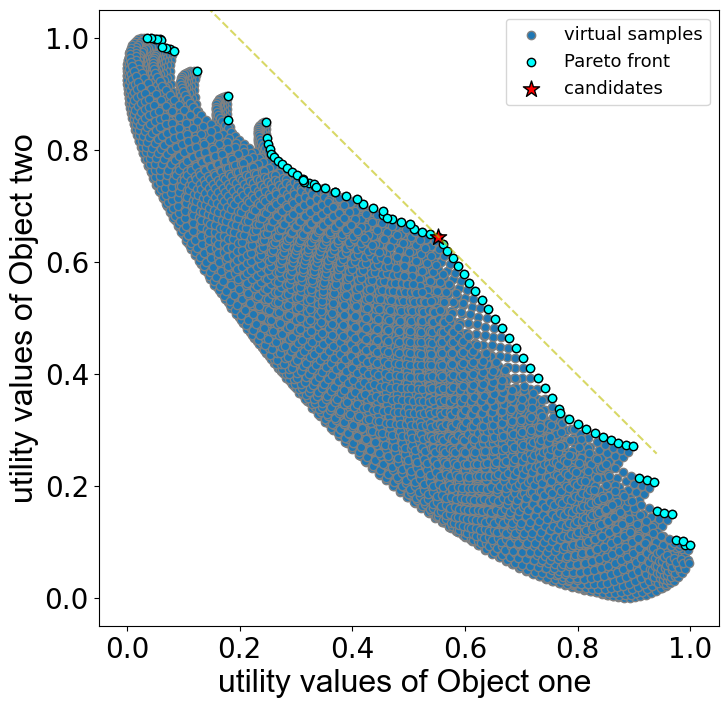

The optimal condidate recommended by BgoKit is : [[94.2  2.1  1.5  0.7]]


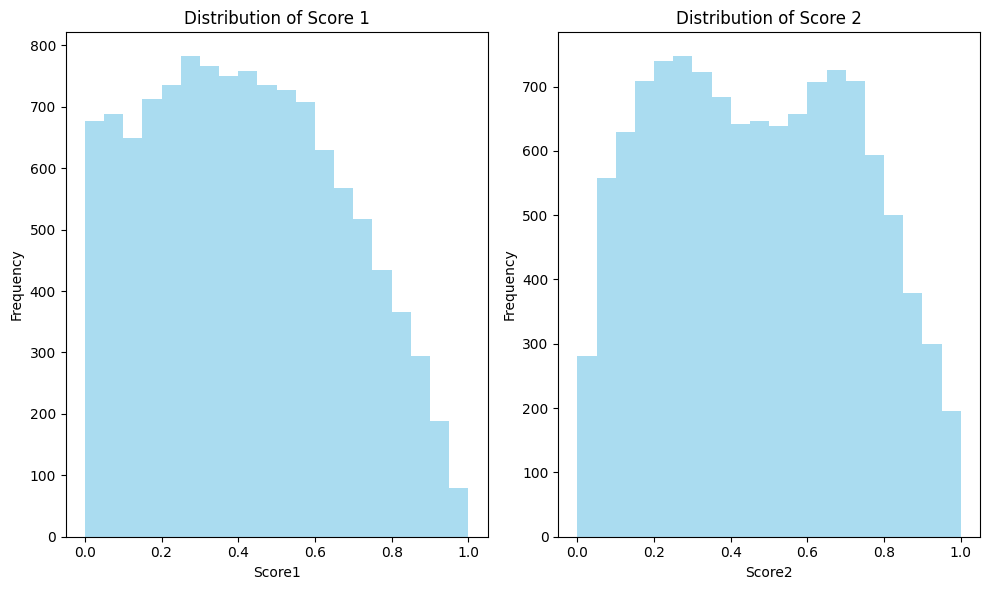

In [9]:
from BgoKit import ToolKit

Model = ToolKit.MultiOpt(vs,[score_T,score_E])
Model.BiSearch()
Model.plot_distribution()

# 考虑两个目标后， 推荐星星点